# Importing ODL geometries

This demo describes how to import ODL geometries. 

This demo requires the following packages (replace `<X.X>` with your currently installed CUDA version):

```sh
conda install pytorch cudatoolkit=<X.X>  astra-toolbox matplotlib tqdm -c astra-toolbox/label/dev -c pytorch
pip install git+https://github.com/ahendriksen/tomosipo.git
# Install the latest version of ODL
pip install git+https://github.com/odlgroup/odl
```


In [21]:
import odl
import torch 
import tomosipo as ts
from medpy.io import load
import matplotlib.pyplot as plt
import numpy as np
from tomosipo.odl import (
    from_odl,
    discretized_space_2d_to_3d,
    parallel_2d_to_3d_geometry,
    fan_to_cone_beam_geometry,
)

def plot_imgs(height=3, cmap="gray", clim=(None, None), **kwargs):
    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(kwargs),
        figsize=(height * len(kwargs), height)
    )
    if len(kwargs) == 1:
        axes = [axes]
    for ax, (k, v) in zip(axes, kwargs.items()):
        # Remove ticks, splines
        ax.set_xticks([])
        ax.set_yticks([])
        for s in ax.spines.values():
            s.set_visible(False)
        
        if isinstance(v, torch.Tensor):
            v = v.detach().cpu().numpy()
        pcm = ax.imshow(v.squeeze(), cmap=cmap, clim=clim)
        fig.colorbar(pcm, ax=ax)
        ax.set_title(k)
    fig.tight_layout()

# 2D fanbeam geometry

This example shows how to convert a 2D fanbeam geometry from ODL. 
In the process, the geometry is first converted to 3D, since tomosipo supports only 3D geometries.

Note that the shape of the sinogram data is different (angle dimension comes first in ODL, in the middle in ASTRA/tomosipo). 
Otherwise, there are no differences between the tomosipo and ODL operators (and their adjoint/transpose).

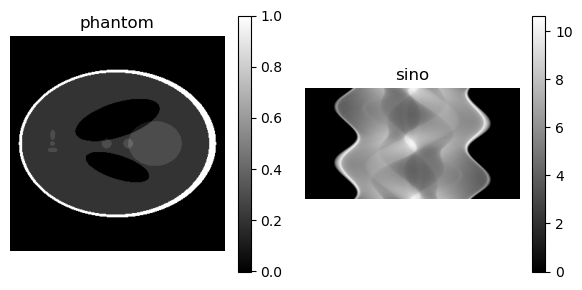

In [3]:
# Create 2D reconstruction space
reco_space = odl.uniform_discr(
    min_pt=[-20, -20], 
    max_pt=[20, 20], 
    shape=[300, 300],
    dtype='float32'
)

# Create 2D fanbeam geometry from reconstruction space:
geometry = odl.tomo.cone_beam_geometry(reco_space, 40, 40, 360)
# Create 2D projection operator
ray_trafo = odl.tomo.RayTransform(reco_space, geometry, impl='astra_cuda')

# Forward project a shepp-logan phantom.
phantom = odl.phantom.shepp_logan(reco_space, modified=True)
proj_data = ray_trafo(phantom)

plot_imgs(phantom=phantom.data, sino=proj_data.data)

In [4]:
vg_odl = discretized_space_2d_to_3d(reco_space)
pg_odl = fan_to_cone_beam_geometry(geometry)
A_odl = odl.tomo.RayTransform(vg_odl, pg_odl, impl='astra_cuda')

vg = from_odl(reco_space)
pg = from_odl(geometry)
A_ts = ts.operator(vg, pg)

                tomosipo      | ODL
------------------------------+--------------
Sinogram shape: (1, 360, 695) | (360, 1, 695)
Volume shape:   (1, 300, 300) | (1, 300, 300)


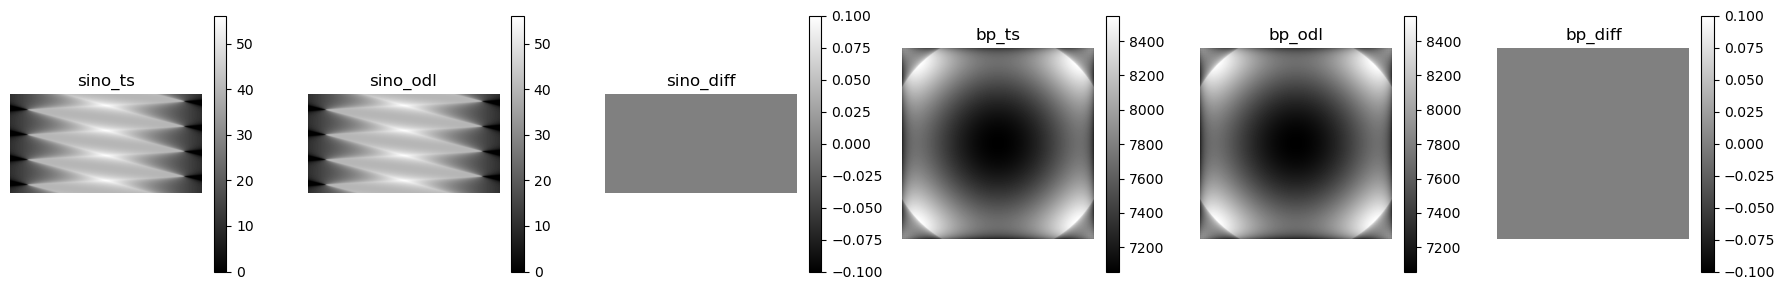

In [5]:
x = np.ones(A_ts.domain_shape, dtype=np.float32)
y_ts = A_ts(x)
y_odl = A_odl(x).data

bp_ts = A_ts.T(y_ts)
bp_odl = A_odl.adjoint(y_odl).data
print("                tomosipo      | ODL")
print("------------------------------+--------------")
print(f"Sinogram shape: {y_ts.shape} | {y_odl.shape}")
print(f"Volume shape:   {bp_ts.shape} | {bp_odl.shape}")
plot_imgs(
    sino_ts=y_ts[0],
    sino_odl=y_odl[:, 0, :],
    sino_diff=y_ts[0] - y_odl[:, 0],
    bp_ts=bp_ts,
    bp_odl=bp_odl,    
    bp_diff=bp_ts - bp_odl,
)

# 2D parallel beam geometry

This example shows how to convert a 2D parallel beam geometry from ODL. 
In the process, the geometry is first converted to 3D, since tomosipo supports only 3D geometries.

Note that the shape of the sinogram data is different (angle dimension comes first in ODL, in the middle in ASTRA/tomosipo). 
Otherwise, there are no differences between the tomosipo and ODL operators (and their adjoint/transpose).

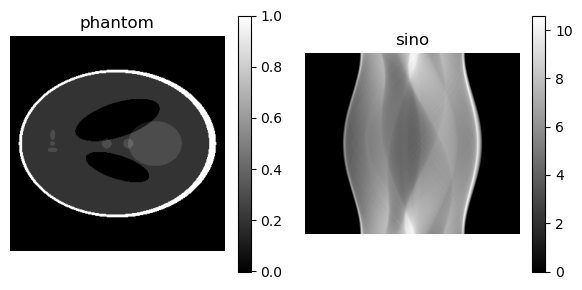

In [6]:
# Create 2D reconstruction space
reco_space = odl.uniform_discr(
    min_pt=[-20, -20], 
    max_pt=[20, 20], 
    shape=[300, 300],
    dtype='float32'
)

# Create 2D parallel beam geometry from reconstruction space:
geometry = odl.tomo.parallel_beam_geometry(reco_space, 360)
# Create 2D projection operator
ray_trafo = odl.tomo.RayTransform(reco_space, geometry, impl='astra_cuda')

# Forward project a shepp-logan phantom.
phantom = odl.phantom.shepp_logan(reco_space, modified=True)
proj_data = ray_trafo(phantom)

plot_imgs(phantom=phantom.data, sino=proj_data.data)

In [7]:
vg_odl = discretized_space_2d_to_3d(reco_space)
pg_odl = parallel_2d_to_3d_geometry(geometry)
A_odl = odl.tomo.RayTransform(vg_odl, pg_odl, impl='astra_cuda')

vg = from_odl(reco_space)
pg = from_odl(geometry)
A_ts = ts.operator(vg, pg)

                tomosipo      | ODL
------------------------------+--------------
Sinogram shape: (1, 360, 427) | (360, 1, 427)
Volume shape:   (1, 300, 300) | (1, 300, 300)


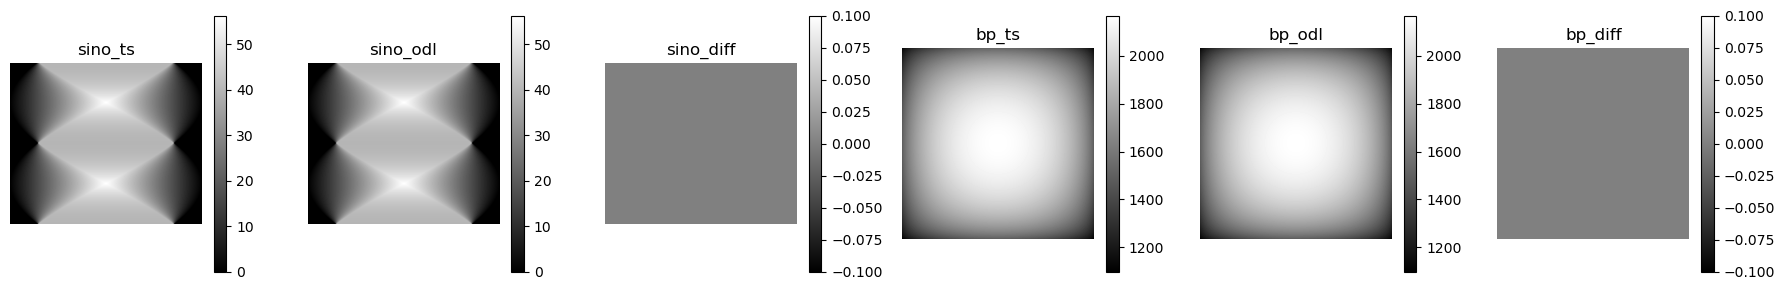

In [8]:
x = np.ones(A_ts.domain_shape, dtype=np.float32)
y_ts = A_ts(x)
y_odl = A_odl(x).data

bp_ts = A_ts.T(y_ts)
bp_odl = A_odl.adjoint(y_odl).data
print("                tomosipo      | ODL")
print("------------------------------+--------------")
print(f"Sinogram shape: {y_ts.shape} | {y_odl.shape}")
print(f"Volume shape:   {bp_ts.shape} | {bp_odl.shape}")
plot_imgs(
    sino_ts=y_ts[0],
    sino_odl=y_odl[:, 0, :],
    sino_diff=y_ts[0] - y_odl[:, 0],
    bp_ts=bp_ts,
    bp_odl=bp_odl,    
    bp_diff=bp_ts - bp_odl,
)

# 3D parallel beam geometry

This example shows how to convert a 3D parallel beam geometry from ODL. 

Note that the shape of the sinogram data is different (angle dimension comes first in ODL, in the middle in ASTRA/tomosipo). 
Otherwise, there are no differences between the tomosipo and ODL operators (and their adjoint/transpose).

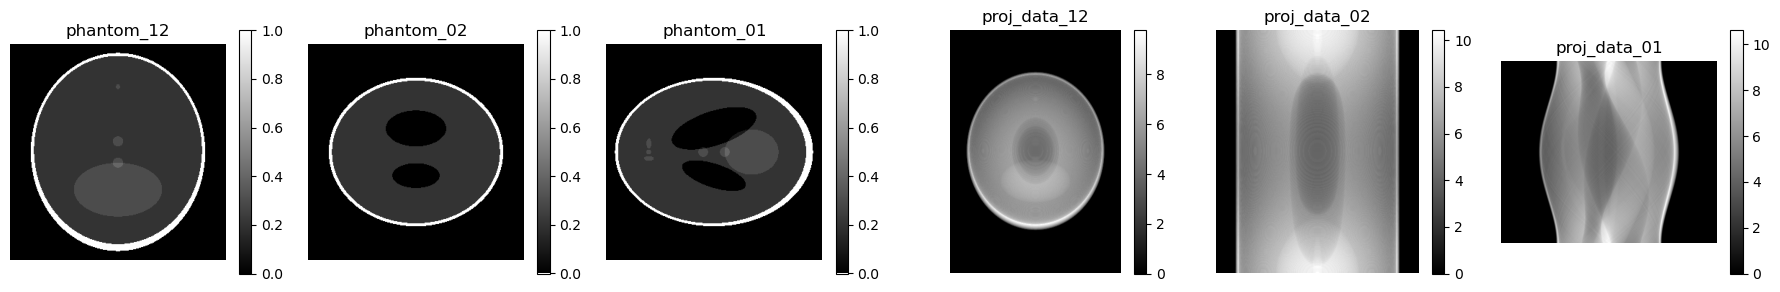

In [9]:
# Create 3D reconstruction space
reco_space = odl.uniform_discr(
    min_pt=[-20, -20, -20], 
    max_pt=[20, 20, 20], 
    shape=[300, 300, 300],
    dtype='float32'
)

# Create 3D parallel beam geometry from reconstruction space:
geometry = odl.tomo.parallel_beam_geometry(reco_space, 360)
# Create 3D projection operator
ray_trafo = odl.tomo.RayTransform(reco_space, geometry, impl='astra_cuda')

# Forward project a shepp-logan phantom.
phantom = odl.phantom.shepp_logan(reco_space, modified=True)
proj_data = ray_trafo(phantom)

# show middle slices in each dimension of phantom and projection data
plot_imgs(phantom_12=phantom.data[149, :, :], phantom_02=phantom.data[:, 149, :], phantom_01=phantom.data[:, :, 149],
          proj_data_12=proj_data.data[179, :, :], proj_data_02=proj_data.data[:, 213, :], proj_data_01=proj_data.data[:, :, 149])

In [10]:
A_odl = ray_trafo

vg = from_odl(reco_space)
pg = from_odl(geometry)
A_ts = ts.operator(vg, pg)

                tomosipo      | ODL
------------------------------+--------------
Sinogram shape: (427, 360, 300) | (360, 427, 300)
Volume shape:   (300, 300, 300) | (300, 300, 300)


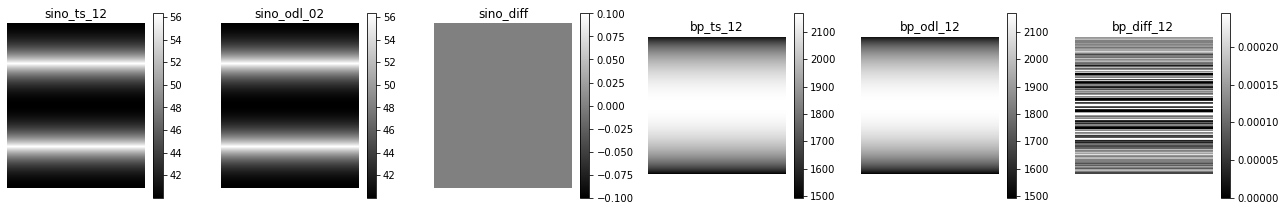

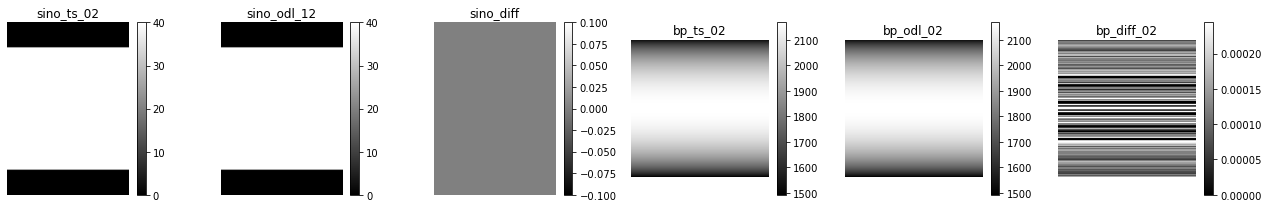

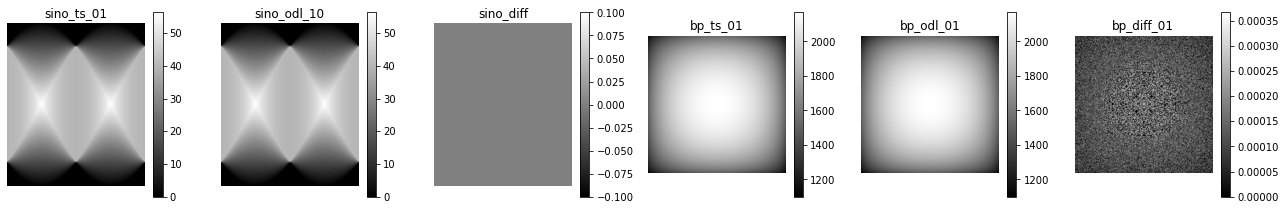

In [10]:
x = np.ones(A_ts.domain_shape, dtype=np.float32)
y_ts = A_ts(x)
y_odl = A_odl(x).data

bp_ts = A_ts.T(y_ts)
bp_odl_weighted = A_odl.adjoint(y_odl).data
# the back-projected data needs to be unweighted (in contrast to the forward projected data where the weight must not be applied)
bp_odl = bp_odl_weighted / A_odl.range.weighting.const * A_odl.domain.weighting.const
print("                tomosipo      | ODL")
print("------------------------------+--------------")
print(f"Sinogram shape: {y_ts.shape} | {y_odl.shape}")
print(f"Volume shape:   {bp_ts.shape} | {bp_odl.shape}")
plot_imgs(
    sino_ts_12=y_ts[213, :, :],
    sino_odl_02=y_odl[:, 213, :],
    sino_diff=y_ts[213, :, :] - y_odl[:, 213, :],
    bp_ts_12=bp_ts[149, :, :],
    bp_odl_12=bp_odl[149, :, :],
    bp_diff_12=bp_ts[149, :, :] - bp_odl[149, :, :],
)
plot_imgs(
    sino_ts_02=y_ts[:, 179, :],
    sino_odl_12=y_odl[179, :, :],
    sino_diff=y_ts[:, 179, :] - y_odl[179, :, :],
    bp_ts_02=bp_ts[:, 149, :],
    bp_odl_02=bp_odl[:, 149, :],
    bp_diff_02=bp_ts[:, 149, :] - bp_odl[:, 149, :],
)
plot_imgs(
    sino_ts_01=y_ts[:, :, 149],
    sino_odl_10=y_odl[:, :, 149].T,
    sino_diff=y_ts[:, :, 149] - y_odl[:, :, 149].T,
    bp_ts_01=bp_ts[:, :, 149],
    bp_odl_01=bp_odl[:, :, 149],
    bp_diff_01=bp_ts[:, :, 149] - bp_odl[:, :, 149],
)

# 3D conebeam geometry

This example shows how to convert a 3D conebeam geometry from ODL. 

Note that the shape of the sinogram data is different (angle dimension comes first in ODL, in the middle in ASTRA/tomosipo). 
Otherwise, there are no differences between the tomosipo and ODL operators (and their adjoint/transpose).

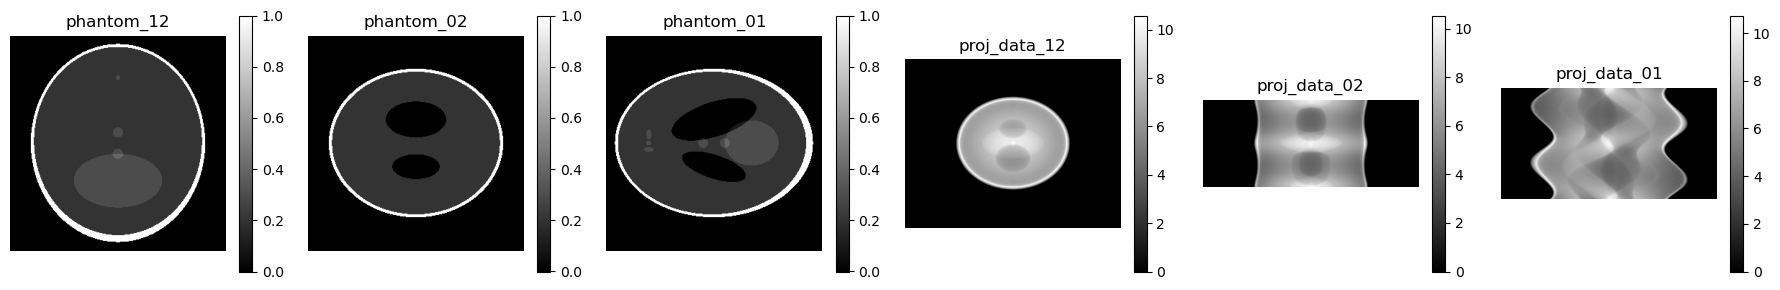

In [11]:
# Create 3D reconstruction space
reco_space = odl.uniform_discr(
    min_pt=[-20, -20, -20], 
    max_pt=[20, 20, 20], 
    shape=[300, 300, 300],
    dtype='float32'
)

# Create 3D conebeam geometry from reconstruction space:
geometry = odl.tomo.cone_beam_geometry(reco_space, 40, 40, 360)
# Create 3D projection operator
ray_trafo = odl.tomo.RayTransform(reco_space, geometry, impl='astra_cuda')

# Forward project a shepp-logan phantom.
phantom = odl.phantom.shepp_logan(reco_space, modified=True)
proj_data = ray_trafo(phantom)

# show middle slices in each dimension of phantom and projection data
plot_imgs(phantom_12=phantom.data[149, :, :], phantom_02=phantom.data[:, 149, :], phantom_01=phantom.data[:, :, 149],
          proj_data_12=proj_data.data[179, :, :], proj_data_02=proj_data.data[:, 347, :], proj_data_01=proj_data.data[:, :, 442])

In [12]:
A_odl = ray_trafo

vg = from_odl(reco_space)
pg = from_odl(geometry)
A_ts = ts.operator(vg, pg)

                tomosipo      | ODL
------------------------------+--------------
Sinogram shape: (695, 360, 884) | (360, 695, 884)
Volume shape:   (300, 300, 300) | (300, 300, 300)


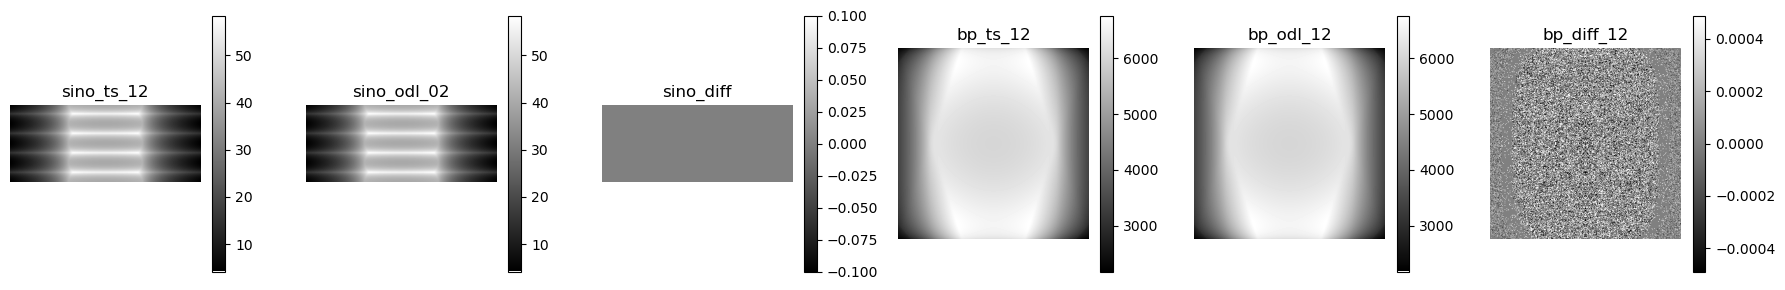

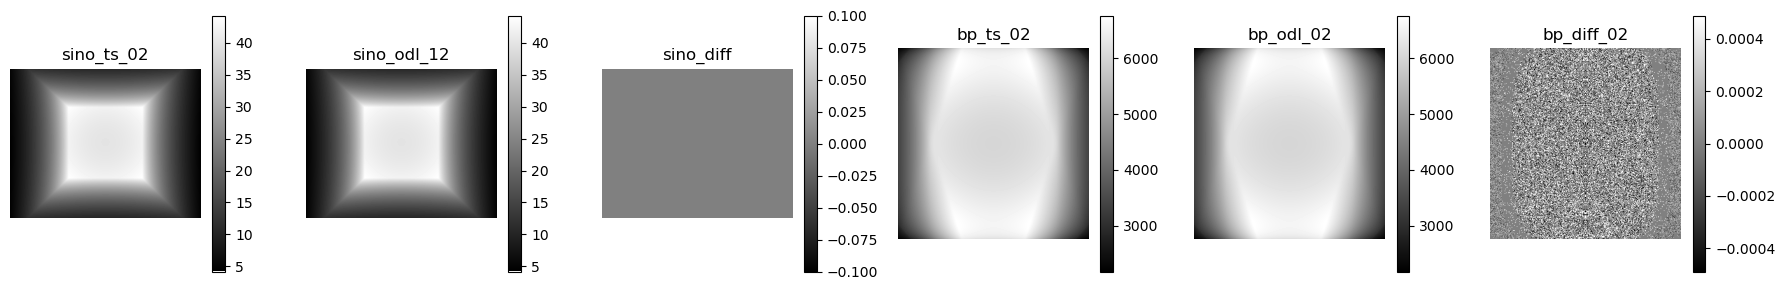

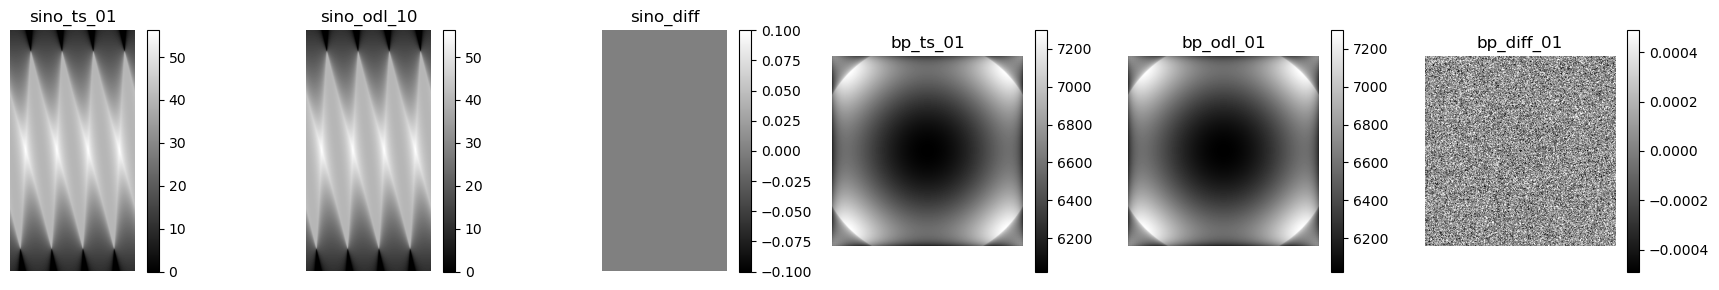

In [13]:
x = np.ones(A_ts.domain_shape, dtype=np.float32)
y_ts = A_ts(x)
y_odl = A_odl(x).data

bp_ts = A_ts.T(y_ts)
bp_odl_weighted = A_odl.adjoint(y_odl).data
# the back-projected data needs to be unweighted (in contrast to the forward projected data where the weight must not be applied)
bp_odl = bp_odl_weighted / A_odl.range.weighting.const * A_odl.domain.weighting.const
print("                tomosipo      | ODL")
print("------------------------------+--------------")
print(f"Sinogram shape: {y_ts.shape} | {y_odl.shape}")
print(f"Volume shape:   {bp_ts.shape} | {bp_odl.shape}")
plot_imgs(
    sino_ts_12=y_ts[347, :, :],
    sino_odl_02=y_odl[:, 347, :],
    sino_diff=y_ts[347, :, :] - y_odl[:, 347, :],
    bp_ts_12=bp_ts[149, :, :],
    bp_odl_12=bp_odl[149, :, :],
    bp_diff_12=bp_ts[149, :, :] - bp_odl[149, :, :],
)
plot_imgs(
    sino_ts_02=y_ts[:, 179, :],
    sino_odl_12=y_odl[179, :, :],
    sino_diff=y_ts[:, 179, :] - y_odl[179, :, :],
    bp_ts_02=bp_ts[:, 149, :],
    bp_odl_02=bp_odl[:, 149, :],
    bp_diff_02=bp_ts[:, 149, :] - bp_odl[:, 149, :],
)
plot_imgs(
    sino_ts_01=y_ts[:, :, 442],
    sino_odl_10=y_odl[:, :, 442].T,
    sino_diff=y_ts[:, :, 442] - y_odl[:, :, 442].T,
    bp_ts_01=bp_ts[:, :, 149],
    bp_odl_01=bp_odl[:, :, 149],
    bp_diff_01=bp_ts[:, :, 149] - bp_odl[:, :, 149],
)

In [27]:
# Create 3D reconstruction space
reco_space = odl.uniform_discr(
    min_pt=[-20, -20, -20], 
    max_pt=[20, 20, 20], 
    shape=[512, 512, 512],
    dtype='float32'
)

# Create 3D conebeam geometry from reconstruction space:
geometry = odl.tomo.cone_beam_geometry(reco_space, 40, 40, 360)
# Create 3D projection operator
ray_trafo = odl.tomo.RayTransform(reco_space, geometry, impl='astra_cuda')

# Forward project a shepp-logan phantom.
phantom = odl.phantom.shepp_logan(reco_space, modified=True)
setattr(phantom, 'data', mage_data)
#phantom.data=mage_data
proj_data = ray_trafo(phantom)

# show middle slices in each dimension of phantom and projection data
plot_imgs(phantom_12=phantom.data[149, :, :], phantom_02=phantom.data[:, 149, :], phantom_01=phantom.data[:, :, 149],
          proj_data_12=proj_data.data[179, :, :], proj_data_02=proj_data.data[:, 347, :], proj_data_01=proj_data.data[:, :, 442])

AttributeError: can't set attribute

In [22]:
np.shape(phantom.data)
base_path='C:/Users/lliu10/OneDrive - Inside MD Anderson/siemenproject/data/'
mage_data, image_header = load(base_path+'17_1.mha')


In [23]:
np.shape(mage_data)

(512, 512, 512)

In [28]:
phantom


uniform_discr(
    [-20., -20., -20.], [ 20.,  20.,  20.], (512, 512, 512),
    dtype='float32'
).element(
    [[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
      [ 0.,  0.,  0., ...,  0.,  0.,  0.],
      [ 0.,  0.,  0., ...,  0.,  0.,  0.],
      ..., 
      [ 0.,  0.,  0., ...,  0.,  0.,  0.],
      [ 0.,  0.,  0., ...,  0.,  0.,  0.],
      [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
    
     [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
      [ 0.,  0.,  0., ...,  0.,  0.,  0.],
      [ 0.,  0.,  0., ...,  0.,  0.,  0.],
      ..., 
      [ 0.,  0.,  0., ...,  0.,  0.,  0.],
      [ 0.,  0.,  0., ...,  0.,  0.,  0.],
      [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
    
     [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
      [ 0.,  0.,  0., ...,  0.,  0.,  0.],
      [ 0.,  0.,  0., ...,  0.,  0.,  0.],
      ..., 
      [ 0.,  0.,  0., ...,  0.,  0.,  0.],
      [ 0.,  0.,  0., ...,  0.,  0.,  0.],
      [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
    
     ..., 
     [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
      [ 0.,